In [4]:
import datetime
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import netrd
import networkx as nx
import scipy.cluster.hierarchy as sch
import osmnx as ox
import pandas as pd
import warnings
import scipy as sp
from pylab import rcParams
from scipy.stats import kendalltau
from collections import defaultdict
from IPython.display import Image
from numpy import array, newaxis
from netrd.distance import QuantumJSD
from networkx.algorithms import isomorphism
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import paired_cosine_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import PCA 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics import silhouette_score
from sklearn.metrics import fowlkes_mallows_score
from sklearn.metrics import jaccard_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import distance_metrics
from sklearn.metrics.pairwise import laplacian_kernel
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import paired_distances
from sklearn import preprocessing
warnings.filterwarnings('ignore')
%matplotlib inline
ox.config(log_console=False, use_cache=False)
weight_by_length = False
ox.__version__

'1.0.1'

In [15]:
# define the study sites as label : query
places = {'Jerusalem'       : 'Jerusalem, Israel',
          'Amsterdam'       : 'Amsterdam, Netherlands',
          'Nairobi'         : 'Nairobi, Kenya',
          'District of Columbia'      : 'District of Columbia, USA',
          'Berlin'          : 'Berlin, Germany',
          'Helsinki'        : 'Helsinki, Finland',
          'Toronto'         : 'Toronto, Canada',
          'St Petersburg'   : 'St Petersburg, Florida, USA',
          'Belgrano'        : 'Belgrano, Buenos Aires, Argentina',
          'Roda Island'     : 'Roda Island, Cairo, Egypt',
          'Jumeirah Islands': 'Jumeirah Islands, Dubai, UAE',
          'Jakarta'         : 'Jakarta, Indonesia',
          'Sydney'          : 'Sydney, Australia',
          'Connaught Place' : 'Connaught Place, New Delhi, India',
          'Champs-Elysees'  : 'Champs-Elysees, Paris, France',
          'Palmanova'       : 'Palmanova,Friuli-Venezia Giulia, Italy',
          'Surulere'        : 'Surulere, Lagos, Nigeria',
          'Athens'          : 'Athens, Greece',
          'Ejecutivo'       : 'Ejecutivo, Mexico City, Mexico',
          'Copenhagen'      : 'Copenhagen, Denmark',
          'Mumbai'          : 'Mumbai, India',
          'City of Westminster'  : 'City of Westminster, London, UK'}

In [16]:
graphs = {}
for place in (places.keys()): 
    # get the graph
    query = places[place]
   
    # Define the reference graph
    G1 = ox.graph_from_address('Jerusalem, Israel', network_type='drive', dist=1000)
    #Define the comparison graphs
    G2 = ox.graph_from_address(query, network_type='drive', dist=1000)
    
    from grakel.utils import graph_from_networkx
    G_nx = [G1, G2]
    
    #Shortest Path
    # Transforms list of NetworkX graphs into a list of GraKeL graphs
    G = graph_from_networkx(G_nx)
    from grakel.kernels import ShortestPath
    gk = ShortestPath(with_labels=False, normalize=True)
    ShortestPath = gk.fit_transform(G)
    sp = round(ShortestPath[0][1], 6)
    
    #Random Walk
    GG = [G1, G2]
    # Transforms list of NetworkX graphs into a list of GraKeL graphs
    graphs = graph_from_networkx(GG)
    # RandomWalk
    from grakel import GraphKernel
    rw_kernel = GraphKernel(kernel=[{"name": "random_walk", "with_labels": False}], normalize=True)
    RWK = rw_kernel.fit_transform(graphs)
    rwk = round(RWK[0][1], 6)
    
    # Converting Graphs to a DiGraph
    G3 = nx.DiGraph(G1)
    G4 = nx.DiGraph(G2)
    
    #NetSimile
    dist = netrd.distance.NetSimile()
    NetSimile = dist.dist(G3, G4)
    NS = 1 / NetSimile
    ns = round (NS, 6)
    
    #Degree Divergence
    degreediv = netrd.distance.DegreeDivergence()
    DegreeDivergence = degreediv.dist(G1, G2)
    DD = 1 - DegreeDivergence
    dd = round (DD, 6)
    
    #Laplacian Spectral
    spectral = netrd.distance.LaplacianSpectral()
    LaplacianSpectral = spectral.dist(G1, G2, normed=True, kernel='normal', hwhm=0.011775, measure='jensen-shannon', k=None, which='LM')
    LS = 1 - LaplacianSpectral
    ls = round (LS, 6)
    
    #NetLSD
    NET = netrd.distance.NetLSD()
    NetLSD = NET.dist(G3, G4)
    NL = 1 / (1+ NetLSD)
    netlsd = round (NL, 6)
    
    # Retrieve nodes
    nodes, edges = ox.graph_to_gdfs(G1)
    #print("Nodes:\n", nodes.head(), '\n')

    #Converting nodes to dataframe
    df = pd.DataFrame(nodes)
    group_1 = ['x']
    group_2 = ['y']
    new_cols = group_1+group_2
    set(df.columns) == set(new_cols)
    X = df[new_cols]

    # Retrieve nodes and edges
    node, edge = ox.graph_to_gdfs(G2)
    #print("Nodes:\n", nodes.head(), '\n')

    #Converting nodes to dataframe
    df3 = pd.DataFrame(node)
    group_1 = ['x']
    group_2 = ['y']
    new_col = group_1+group_2
    set(df3.columns) == set(new_col)
    Y = df3[new_col]

    # Cosine Similarity
    Cs = cosine_similarity(X, Y)
    cs = round(Cs[0][1], 6)

    #Eucledian Distance
    Ed = euclidean_distances (X, Y)
    ED = 1 / (1+ Ed)
    ed = round(ED[0][1], 6)

    # Jaccard similarity
    def jaccard_similarity(G1, G2):
        i = set(G1).intersection(G2)
        return round(len(i) / (len(G1) + len(G2) - len(i)),6)

    JS = jaccard_similarity(G1.edges(), G2.edges())

    # Jaccard Distance
    distjd = netrd.distance.JaccardDistance()
    JD = distjd.dist(G1, G2)
    Jd = 1 / (1+ JD)

    print(place, sp, rwk, ns, dd, ls, netlsd, cs, ed, JS, Jd)

Jerusalem 1.0 1.0 inf 1 1.0 1.0 1.0 0.985374 0.991525 1.0
Amsterdam 0.990445 0.999499 0.102993 0.959865 0.903508 0.001778 0.736353 0.026568 0.0 0.5
Nairobi 0.994408 0.993902 0.144144 0.99097 0.889542 0.001012 0.71821 0.029302 0.0 0.5
District of Columbia 0.903349 0.418758 0.097426 0.840639 0.774833 0.001437 -0.360198 0.008816 0.0 0.5
Berlin 0.879194 0.71027 0.113772 0.886668 0.818601 0.00049 0.832788 0.032158 0.0 0.5
Helsinki 0.966701 0.885884 0.133992 0.944105 0.853475 0.001085 0.903366 0.032087 0.0 0.5
Toronto 0.749295 0.704195 0.083366 0.833242 0.781885 0.000546 -0.32727 0.008605 0.0 0.5
St Petersburg 0.842785 nan 0.06483 0.656481 0.732059 0.000647 -0.490113 0.008407 0.0 0.5
Belgrano 0.876557 0.999594 0.07152 0.930944 0.796092 0.000719 -0.979943 0.008635 0.0 0.5
Roda Island 0.925173 0.679748 0.099781 0.820532 0.80582 0.000193 0.999516 0.186667 0.0 0.5
Jumeirah Islands 0.791326 0.999297 0.091245 0.875262 0.645369 0.000244 0.952907 0.045338 0.0 0.5
Jakarta 0.994452 0.99445 0.116706 0.

In [5]:
# Data Visualisation Settings 
%matplotlib inline
rcParams['figure.figsize'] = 5,4
sb.set_style('whitegrid')

In [6]:
# Import the data
similarity_analysis = pd.read_csv("cul_de_sac_similarity.csv")
similarity_analysis.head()

,City,Country,Road Network Pattern (Drive),Shortest Path,Random Walk,Net Simile,Degree Divergence,Laplacian Spectral,NetLSD,Cosine Similarity,Eucledian Distances,Jaccard Similarity,Jaccard Distance
0,Jerusalem,Israel,Cul-de-sac (Reference Graph),1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.985374,0.991525,1.0
1,Amsterdam,Netherlands,Cul-de-Sac,0.965993,0.999786,0.109330,0.954346,0.903148,0.002585,0.736353,0.026568,0.000000,0.5
2,Nairobi,Kenya,Radial,0.994408,0.993902,0.144144,0.990970,0.889542,0.001012,0.718210,0.029302,0.000000,0.5
3,District of Columbia,USA,Grid,0.915245,0.647009,0.096756,0.848819,0.781039,0.001948,-0.360050,0.008817,0.000000,0.5
4,Berlin,Germany,Grid,0.779096,0.935018,0.096539,0.862781,0.805078,0.000422,0.832697,0.032154,0.000000,0.5


In [7]:
New = similarity_analysis.drop(columns=['City', 'Country', 'Road Network Pattern (Drive)'])
New.head()

,Shortest Path,Random Walk,Net Simile,Degree Divergence,Laplacian Spectral,NetLSD,Cosine Similarity,Eucledian Distances,Jaccard Similarity,Jaccard Distance
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.985374,0.991525,1.0
1,0.965993,0.999786,0.109330,0.954346,0.903148,0.002585,0.736353,0.026568,0.000000,0.5
2,0.994408,0.993902,0.144144,0.990970,0.889542,0.001012,0.718210,0.029302,0.000000,0.5
3,0.915245,0.647009,0.096756,0.848819,0.781039,0.001948,-0.360050,0.008817,0.000000,0.5
4,0.779096,0.935018,0.096539,0.862781,0.805078,0.000422,0.832697,0.032154,0.000000,0.5


In [8]:
labels = ['Jerusalem', 'Amsterdam', 'Nairobi', 'District of Columbia', 'Berlin', 'Helsinki', 'Toronto', 
          'St, Petersburg, Florida', 'Belgrano, Buenos Aires', 'Roda Island, Cairo', 'Jumeirah Islands, Dubai', 'Jakarta', 'Sydney', 'Connaught Place, New Delhi', 'Champs-Elysees, Paris',
         'Palmanova,Italy', 'Surulere, Lagos', 'Athens', 'Ejecutivo, Mexico City', 'Copenhagen', 'Mumbai', 'City of Westminster, London']

In [9]:
labels2 = ['Shortest Path', 'Random Walk', 'Net Simile', 'Degree Divergence', 'Laplacian Spectral', 'NetLSD', 'Cosine Similarity', 'Eucledian Distances', 'Jaccard Similarity', 'Jaccard Distance']

In [10]:
corr = New.corr(method='kendall')
corr

,Shortest Path,Random Walk,Net Simile,Degree Divergence,Laplacian Spectral,NetLSD,Cosine Similarity,Eucledian Distances,Jaccard Similarity,Jaccard Distance
Shortest Path,1.000000,0.073593,0.480519,0.532468,0.575758,0.373103,0.151515,0.203463,0.301511,0.301511
Random Walk,0.073593,1.000000,-0.099567,0.264069,0.203463,-0.008677,0.038961,0.177489,0.272796,0.272796
Net Simile,0.480519,-0.099567,1.000000,0.272727,0.367965,0.147506,0.359307,0.393939,0.301511,0.301511
Degree Divergence,0.532468,0.264069,0.272727,1.000000,0.593074,0.303688,0.082251,0.220779,0.301511,0.301511
Laplacian Spectral,0.575758,0.203463,0.367965,0.593074,1.000000,0.390456,0.264069,0.264069,0.301511,0.301511
NetLSD,0.373103,-0.008677,0.147506,0.303688,0.390456,1.000000,-0.208243,-0.086768,0.302166,0.302166
Cosine Similarity,0.151515,0.038961,0.359307,0.082251,0.264069,-0.208243,1.000000,0.688312,0.301511,0.301511
Eucledian Distances,0.203463,0.177489,0.393939,0.220779,0.264069,-0.086768,0.688312,1.000000,0.301511,0.301511
Jaccard Similarity,0.301511,0.272796,0.301511,0.301511,0.301511,0.302166,0.301511,0.301511,1.000000,1.000000
Jaccard Distance,0.301511,0.272796,0.301511,0.301511,0.301511,0.302166,0.301511,0.301511,1.000000,1.000000


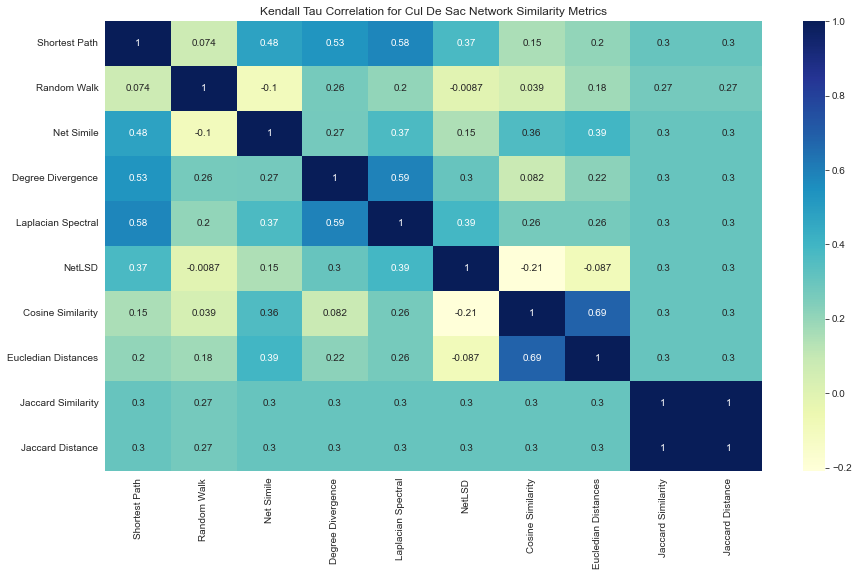

In [11]:
#Heatmap For Kendall Tau Correlation of Network Similarity Metrics
rcParams['figure.figsize'] = 14.7,8.27
sb.heatmap(corr, 
           xticklabels=corr.columns.values, 
           yticklabels=corr.columns.values, 
           cmap="YlGnBu",
          annot=True)
plt.title("Kendall Tau Correlation for Cul De Sac Network Similarity Metrics")
plt.savefig('culdesac2.png', dpi=200, bbox_inches='tight')

In [12]:
# Normalizing the data to plot histogram for road network similarity metrics
from sklearn.preprocessing import normalize
data_scaled = normalize(New)
data_scaled = pd.DataFrame(data_scaled, columns=New.columns)
data_scaled.head()

,Shortest Path,Random Walk,Net Simile,Degree Divergence,Laplacian Spectral,NetLSD,Cosine Similarity,Eucledian Distances,Jaccard Similarity,Jaccard Distance
0,0.316956,0.316956,0.316956,0.316956,0.316956,0.316956,0.316956,0.312320,0.31427,0.316956
1,0.457203,0.473198,0.051746,0.451691,0.427459,0.001223,0.348515,0.012575,0.00000,0.236649
2,0.466830,0.466592,0.067669,0.465216,0.417600,0.000475,0.337167,0.013756,0.00000,0.234727
3,0.530553,0.375061,0.056088,0.492047,0.452756,0.001129,-0.208715,0.005111,0.00000,0.289842
4,0.398228,0.477926,0.049345,0.441003,0.411508,0.000216,0.425626,0.016435,0.00000,0.255571


In [13]:
# Normalizing the data to plot histogram for road network clusters
from sklearn.preprocessing import normalize
data = normalize(corr)
data = pd.DataFrame(data, columns=corr.columns)
data.head()

,Shortest Path,Random Walk,Net Simile,Degree Divergence,Laplacian Spectral,NetLSD,Cosine Similarity,Eucledian Distances,Jaccard Similarity,Jaccard Distance
0,0.668644,0.049208,0.321297,0.356031,0.384977,0.249473,0.101310,0.136044,0.201604,0.201604
1,0.064338,0.874241,-0.087046,0.230860,0.177876,-0.007586,0.034061,0.155168,0.238490,0.238490
2,0.345130,-0.071513,0.718244,0.195885,0.264289,0.105945,0.258070,0.282945,0.216559,0.216559
3,0.366659,0.181839,0.187801,0.688604,0.408393,0.209121,0.056638,0.152029,0.207622,0.207622
4,0.376887,0.133186,0.240867,0.388222,0.654593,0.255590,0.172858,0.172858,0.197367,0.197367


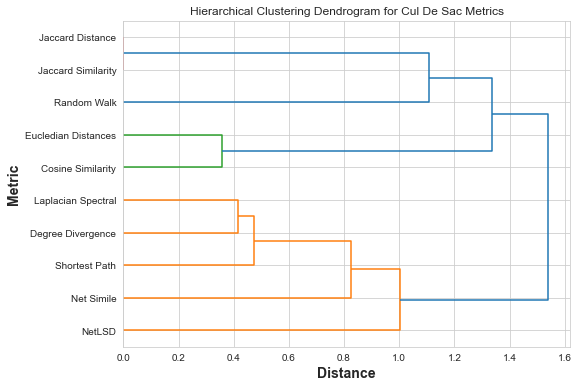

In [13]:
# Plot of the Histogram for Road Network Simiarity Metrics
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(8, 6)) 
plt.xlabel('Distance', weight = 'bold', fontsize=14)
plt.ylabel('Metric', weight = 'bold', fontsize=14)
plt.title("Hierarchical Clustering Dendrogram for Cul De Sac Metrics")  
dend = shc.dendrogram(shc.linkage(data, method='ward'), labels=labels2, leaf_rotation=0., leaf_font_size=10., orientation="right")
plt.savefig('culdesac_metrics_dendrogram.png', dpi=200, bbox_inches='tight')

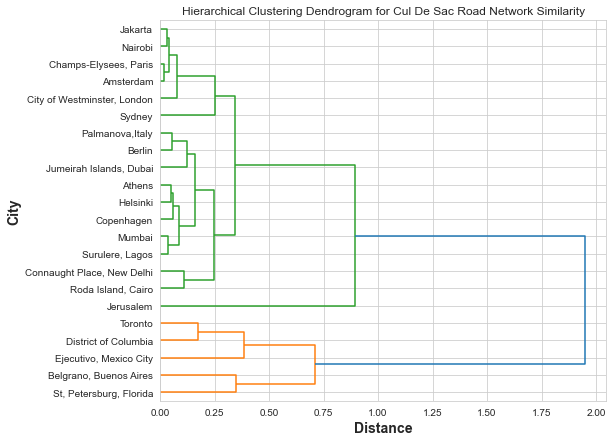

In [14]:
# Plot of the Histogram for Similar Road Networks
plt.figure(figsize=(8, 7))  
plt.xlabel('Distance', weight = 'bold', fontsize=14)
plt.ylabel('City', weight = 'bold', fontsize=14)
plt.title("Hierarchical Clustering Dendrogram for Cul De Sac Road Network Similarity")   
#dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'),labels=labels, leaf_rotation=90., leaf_font_size=10.,)
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'),labels=labels, leaf_rotation=0., leaf_font_size=10., orientation="right")
plt.savefig('culdesac_dendrogram2.png', dpi=200, bbox_inches='tight')

In [15]:
similarity_analysis.head()

,City,Country,Road Network Pattern (Drive),Shortest Path,Random Walk,Net Simile,Degree Divergence,Laplacian Spectral,NetLSD,Cosine Similarity,Eucledian Distances,Jaccard Similarity,Jaccard Distance
0,Jerusalem,Israel,Cul-de-sac (Reference Graph),1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.985374,0.991525,1.0
1,Amsterdam,Netherlands,Cul-de-Sac,0.965993,0.999786,0.109330,0.954346,0.903148,0.002585,0.736353,0.026568,0.000000,0.5
2,Nairobi,Kenya,Radial,0.994408,0.993902,0.144144,0.990970,0.889542,0.001012,0.718210,0.029302,0.000000,0.5
3,District of Columbia,USA,Grid,0.915245,0.647009,0.096756,0.848819,0.781039,0.001948,-0.360050,0.008817,0.000000,0.5
4,Berlin,Germany,Grid,0.779096,0.935018,0.096539,0.862781,0.805078,0.000422,0.832697,0.032154,0.000000,0.5


In [16]:
s = similarity_analysis.drop(columns=['Country', 'Road Network Pattern (Drive)' ])

In [17]:
updated = s.set_index('City')

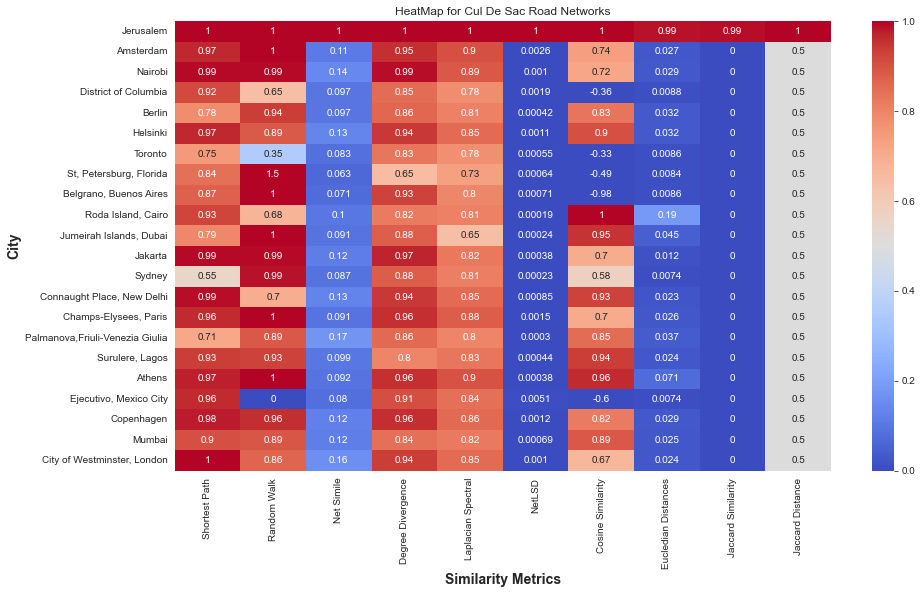

In [18]:
#Plot for the Heatmap of Similar Road Networks
rcParams['figure.figsize'] = 14.7,8.27
sb.heatmap(updated, cmap='coolwarm', annot=True, vmin=0, vmax=1)
plt.title("HeatMap for Cul De Sac Road Networks")
plt.xlabel('Similarity Metrics', weight = 'bold', fontsize=14)
plt.ylabel('City', weight = 'bold', fontsize=14)
plt.savefig('Culdesacheatmap.png', dpi=200, bbox_inches='tight')